# 1. Preparing our data

## 1.1 Description of the raw data

Our raw data is given in the form of three vectors:

* x: energy
* y: number of photons
* y_err: error in y, which should be in our case equal to $\sqrt{y}$

These vectors are placed in the file corresponding to that spectrum, for example

|    X,eV     |   Y      | Y err    |
|----------|----------|----------|
| 6025.88  | 588.0    | 24.25    |
| 6063.11  | 637.0    | 25.24    |
| 6100.57  | 651.0    | 25.51    |
| 6138.25  | 580.0    | 24.08    |
| 6176.17  | 676.0    | 26.0     |
| 6214.33  | 768.0    | 27.71    |

## 1.2 Lower the number of channels

Our spectra are given in the energy range $\left[100,300k\right]$ eV. But we are interested mostly on ~ $\left[1,50\right]$ keV. In addition, we want to reduce the number of channels (energy-bins) because it will have a negative impact on the performance of the DL (Deep Learning) model. There are different ways to achieve this, and we can change this later, therefore now we will simply average neighbor energy bins. This will also help us to smoothen a little bit the spectra. 


The number of channels in the energy distribution is 159


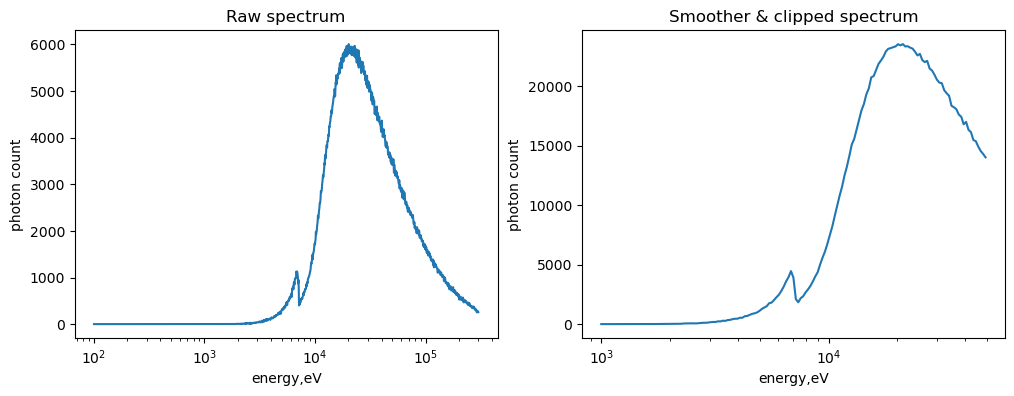

In [1]:
from one_time_utilities import *

x_raw, y_raw, _ = x_y_z(path=".dummydata/224_-1_1xfe_6070_51_8.9e+20_1.1e+26_33_CONTINUUM_NONE.spectrum")

x_smooth,y_smooth = reduce_energy_bins_number(x_raw,y_raw,times_=2)
x_clipped, y_clipped = clip_spectrum(x_smooth,y_smooth,energy_left=1e3,energy_right=50e3)

plot_pair_spectra(x_raw,y_raw,x_clipped,y_clipped,title_left="Raw spectrum",title_right="Smoother & clipped spectrum")

print(f"The number of channels in the energy distribution is {len(x_clipped)}")

## 1.3 Normalization

In order to pass our data into the DL model we will normalize the spectra with the given formula (see: https://arxiv.org/abs/2206.04602):

$$
y = \frac{y_{count} - \overline{y_{count}}}{\sigma (y_{count})}
$$

By using the pevious formula, all our spectra will have the same mean value of $0$, and the same standard deviation of $1$.

Later we will pass that normalized $y$ to our DL model.

Mean value: 0.00,    Stdev: 1.00


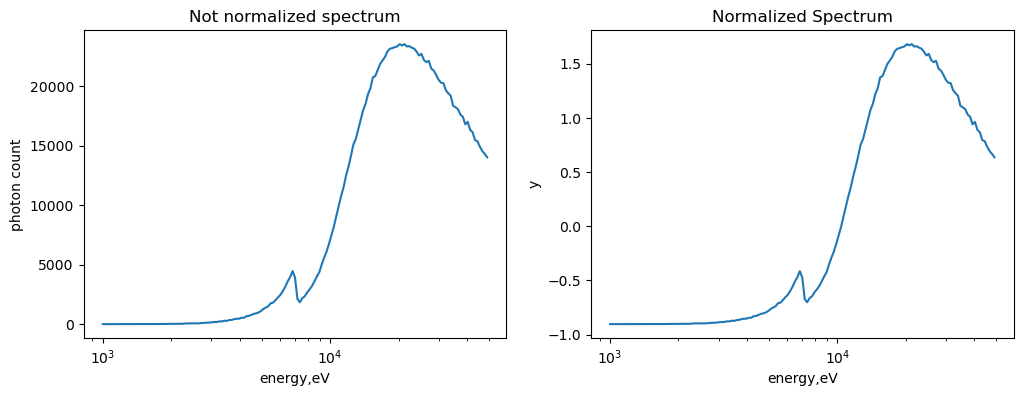

In [2]:
x_normalized, y_normalized = normalize_spectrum(x_clipped,y_clipped)

plot_pair_spectra(x_clipped,y_clipped,
                  x_normalized,y_normalized,
                  title_left="Not normalized spectrum", 
                  title_right="Normalized Spectrum", 
                  y_label_right="y")

print(f"Mean value: {np.mean(y_normalized):.2f},    Stdev: {np.std(y_normalized):0.2f}")

## 1.4 Finishing the preparation of the spectra

Now we can combine the previous operations into a single function.

Mean value: 0.00,    Stdev: 1.00


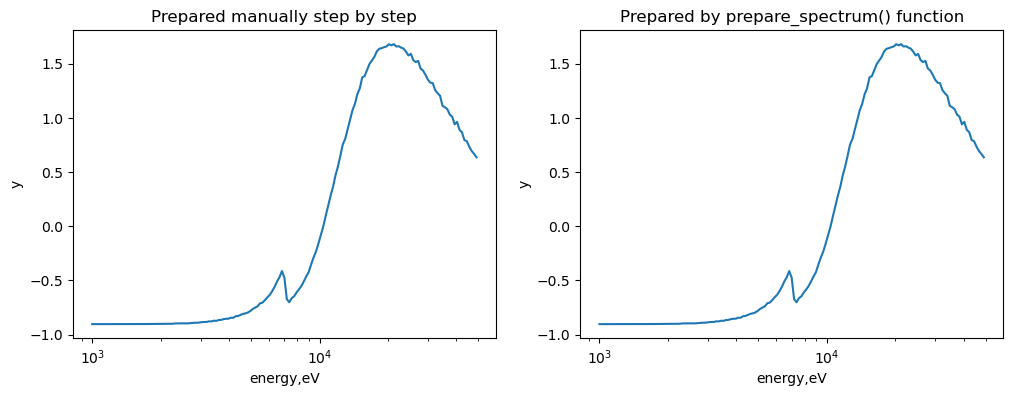

In [3]:
x_prepared, y_prepared = prepare_spectrum(x_raw=x_raw,y_raw=y_raw,energy_left=1e3, energy_right=50e3, squeezin_factor=2)

# Let's compare both retults, we expect them to be equal
plot_pair_spectra(x_normalized,y_normalized,
                  x_prepared,y_prepared,
                  title_left="Prepared manually step by step", 
                  title_right="Prepared by prepare_spectrum() function", 
                  y_label_right="y",y_label_left="y")

print(f"Mean value: {np.mean(y_normalized):.2f},    Stdev: {np.std(y_normalized):0.2f}")

## 1.4 Build the spectrum class

We now need to extract the label data from the spectrum file.

Each spectrum file name is given in the the form:

* `nha`: average colum density in $cm^{-2}$
* `n`: average number of clouds
* `afe`: Iron abundance, relative to the standard solar abundance
* `alpha`: viewing angle
* `col_density_description`: describes the column density intervals
* `nh`: column density interval id on the line of sight
* `component`: spectrum component type
* `fluorescent_line`: if the spectrum component corresponds to a fluorescent line, then this parameter indicates which line (e.g. FeKalpha)
* `spectrum_type`: (1) spectrum or (2) fluxdensity. The word spectrum means photon count distribution, and fluxdensity means the normalized fluxdensities. However, we care for now only on the photon counts.

In addition, we will also put the corresponding normalized spectrum in the same class.


In [4]:
normalized_spectrum_info = NormalizedSpectrumInfo.build_normalized_spectrum_info(".dummydata/224_-1_1xfe_6070_51_8.9e+20_1.1e+26_33_CONTINUUM_NONE.spectrum")
len(normalized_spectrum_info.y)

159

At this moment we have our data (spectrum) and its different features given in a single data class. 

## 1.5 Building the spectrum-abundances pairs

Now, we want to build the numpy arrays of features-targets, where the features are the normalized spectra and the targets are the abundances of Iron.

> We will first try to determine the Iron abundances with DL because at the moment we can do this by spectral fitting. Thus, if we manage to accomplish this same task with DL, we will be able to compare both approaches better, before we attempt to determine other physical properties of the AGN torus.


In [5]:
from paths_in_this_machine import ROOT_DIRECTORIES

generate_train_and_test_paths_files(ROOT_DIRECTORIES,train_data_fraction=0.90)

train_paths, test_paths = get_train_and_test_paths(
    train_paths_file_path="train_spectra_paths.txt",
    test_paths_file_path="test_spectra_paths.txt"
)

# some spectra migh have too few photons and therefore they can produce
# strange values of stdev and mean, thus we will filter out those spectra
# for which our normalization formula is NaN. To do this, it's enough to use a try/except block

unprocessed_train_data_labels_pairs = []
unprocessed_train_data_tags = []
for spectrum_path in train_paths:
    try:
        spectrum_info = NormalizedSpectrumInfo.build_normalized_spectrum_info(spectrum_path.strip(),squeezing_factor=3)
        unprocessed_train_data_labels_pairs += [(spectrum_info.y,int(spectrum_info.n))]
        unprocessed_train_data_tags+=[spectrum_info.file_name]
    except Exception as err:
        continue

unprocessed_test_data_labels_pairs = []
unprocessed_test_data_tags = []
for spectrum_path in test_paths:
    try:
        spectrum_info = NormalizedSpectrumInfo.build_normalized_spectrum_info(spectrum_path.strip(),squeezing_factor=3)
        unprocessed_test_data_labels_pairs += [(spectrum_info.y,int(spectrum_info.n))]
        unprocessed_test_data_tags+=[spectrum_info.file_name]
    except Exception as e:
        continue
        
print(f"Length of train data: {len(unprocessed_train_data_labels_pairs)}")
print(f"Length of test data: {len(unprocessed_test_data_labels_pairs)}")

Train or test spectra paths file exist. You have to manually delete them both if you want to generate new ones!
Length of train data: 3477
Length of test data: 360


24_2_1xfe_7080_51_8.9e+20_1.1e+26_32_FULL_ALL


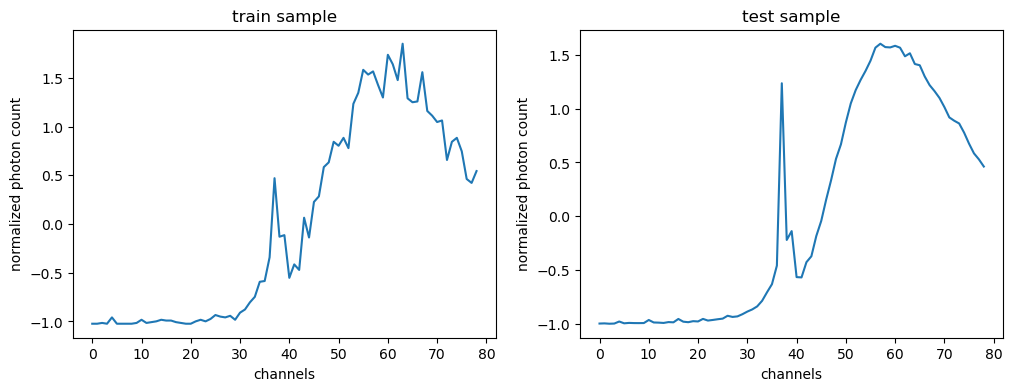

In [6]:
y_train = unprocessed_train_data_labels_pairs[20][0]
y_test = unprocessed_test_data_labels_pairs[21][0]
print(unprocessed_test_data_tags[21])
x_channels = np.arange(0,len(y_train))
plot_pair_spectra(x_channels,y_train,x_channels,y_test,
                  title_left="train sample", title_right="test sample",
                  y_label_left="normalized photon count",
                  y_label_right="normalized photon count",
                  x_label_left="channels",
                  x_label_right="channels",
                  x_scale="linear")

# 2. Building the custom dataset 

Before we can build our DL model we need to create a custom dataset to input our data into the pytorch DL model.

In [7]:
import torch
from torch.utils.data import Dataset

# we want to make our code device agnostic
device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"

class SpectraDataset(Dataset):
    """
    The input data should be a list of pairs [(y1, label1), (y2, label2), ...]
    """
    
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        y, label = self.data[idx]
        # Convert to PyTorch tensors if not already
        y_tensor = torch.from_numpy(y).to(device).float()
        label_tensor = torch.tensor(label).to(device).float()
        return y_tensor, label_tensor

In [8]:
train_spectral_dataset = SpectraDataset(unprocessed_train_data_labels_pairs)
test_spectral_dataset = SpectraDataset(unprocessed_test_data_labels_pairs)

# 3. Creating the data loaders

We need to create the data loaders in order to make our cursom data sets iterable objects, and to be able to work in batches. 

In [9]:
from torch.utils.data import DataLoader

BATCH_SIZE = 64
train_dataloader = DataLoader(train_spectral_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_spectral_dataset, batch_size=BATCH_SIZE, shuffle=True)
print(f"Num of train data batches: {len(train_dataloader)}")
print(f"Num of test data batches: {len(test_dataloader)}")

# Let's investigate what's inside the first train data batch
train_features, train_labels = next(iter(train_dataloader))
test_features, test_labels = next(iter(test_dataloader))
iter2 = iter(test_dataloader)
iter3 = iter(test_dataloader)
iter4 = iter(test_dataloader)
next(iter2)
next(iter3)
next(iter4)
test_features2, test_labels2 = next(iter2)
next(iter3)
test_features3, test_labels3 = next(iter3)
next(iter4)
next(iter4)
test_features4, test_labels4 = next(iter4)
print(f"Shape of the features per batch: {train_features.shape}")
print(f"Shape of the labels per batch: {train_labels.shape}")
train_features[0]

Num of train data batches: 55
Num of test data batches: 6
Shape of the features per batch: torch.Size([64, 79])
Shape of the labels per batch: torch.Size([64])


tensor([-0.8747, -0.8668, -0.8866, -0.8747, -0.8231, -0.8747, -0.8707, -0.8787,
        -0.8866, -0.8707, -0.7874, -0.8548, -0.8787, -0.8509, -0.8628, -0.8509,
        -0.7596, -0.8509, -0.8271, -0.8350, -0.7993, -0.8191, -0.8350, -0.8112,
        -0.8152, -0.7834, -0.7318, -0.7834, -0.7437, -0.7715, -0.7120, -0.7080,
        -0.7120, -0.7159, -0.6485, -0.5731, -0.5175,  0.3516, -0.5810, -0.4818,
        -0.4858, -0.6445, -0.4699, -0.4699, -0.4183, -0.4183, -0.4342, -0.3191,
        -0.3270, -0.1881, -0.1008,  0.0540,  0.2841,  0.4627,  0.5699,  0.8675,
         0.9985,  1.3437,  1.4469,  1.7803,  1.7525,  1.8557,  2.0224,  1.9470,
         2.0343,  1.8874,  1.9827,  1.8993,  1.7049,  1.5580,  1.2525,  1.3755,
         1.2167,  0.9191,  0.9231,  0.7643,  0.6889,  0.5183,  0.4230])

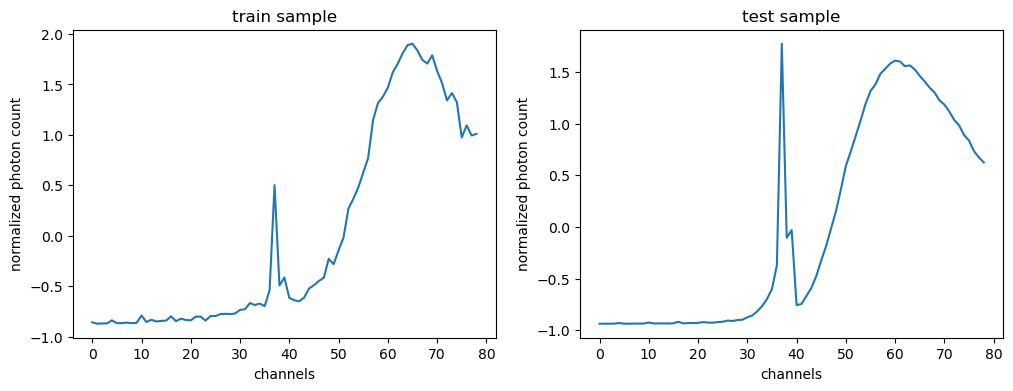

In [10]:
# Let's show a train and a test samples inside our dataloaders
# chosen randomly, from the first batch
train_features_id = torch.randint(0,len(train_features),size=[1])
test_features_id = torch.randint(0,len(test_features),size=[1])

y_train = train_features[train_features_id].squeeze().cpu().numpy()
y_test = test_features[test_features_id].squeeze().cpu().numpy()
x_channels = np.arange(0,len(y_train))

plot_pair_spectra(x_channels,y_train,x_channels,y_test,
                  title_left="train sample", title_right="test sample",
                  y_label_left="normalized photon count",
                  y_label_right="normalized photon count",
                  x_label_left="channels",
                  x_label_right="channels",
                  x_scale="linear")

# 4. Creating the PyTorch DL model

Now we create our DL model for AGN spectral analysis.

In [11]:
from torch import nn

class AGNSpectralDLModelForIronAbundance(nn.Module):
    
    def __init__(self, input_shape,hidden_units, output_shape):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(in_features=input_shape,out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=hidden_units),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=hidden_units,out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=output_shape)
        )
    
    def forward(self, x):
        return self.layer_stack(x)


In [12]:
torch.manual_seed(42)
spectral_model = AGNSpectralDLModelForIronAbundance(input_shape=79,hidden_units=256,output_shape=1).to(device)
next(iter(spectral_model.parameters())).shape

torch.Size([256, 79])

In [13]:
# test that our model is able to return a result
dummy_x = torch.rand([79]).to(device)
with torch.inference_mode():
    print(spectral_model(dummy_x))

tensor([0.0486])


# 5. Creating the loss function, optimizer and timing code

We then need to create the loss function and optimizer, of course we can change these in the future.

In [14]:
# Let's now create the loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(params=spectral_model.parameters(),lr=0.001)

In [15]:
# In addition we need to time our model, thus we need the following code for that

from timeit import default_timer as timer
from tqdm.auto import tqdm
start_time = timer()
# some code ...
end_time = timer()
print_train_time(start=start_time,end=end_time,device="cpu")


Train time on cpu: 0.000 seconds


1.0241055861115456e-05

# 6. The train and test loop

Now we need to code the loop that trains and also tests our model.

In [16]:
train_time_start_on_cpu = timer()

# set the number of epochs
epochs = 7_000

# Create training and test loops
for epoch in tqdm(range(epochs)):
    ### TRAINING
    
    # in this variable we'll accumulate the training loss per batch, for all the batches
    # and at the end of the loop we will divide this by the num of batches
    # to get the train loss per epoch
    train_loss = 0
    
    # loop through the training batches
    # recall: X is a spectrum, y is the corresponding Iron abundance
    for batch, (X,y) in enumerate(train_dataloader):
        spectral_model.train()
        y_pred = spectral_model(X)
        loss = loss_fn(y_pred.squeeze(),y)
        train_loss += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print out what's happenin'
        if epoch % 200 == 0 and batch % 200 == 0:
            print(f"Looked at {batch*BATCH_SIZE}/{len(train_dataloader.dataset)} samples.")
            
    # divide total train loss by length of train_data_loader
    train_loss /= len(train_dataloader)

    ### TESTING
    test_loss, test_acc = 0,0
    spectral_model.eval()
    with torch.inference_mode():
        for X_test,y_test in test_dataloader:
            # 1. Forward pass
            test_pred = spectral_model(X_test)
            
            # 2. Calculate the loss
            loss = loss_fn(test_pred.squeeze(),y_test)
            test_loss += loss
            
        # calculate the test loss average per batch
        test_loss /= len(test_dataloader)
        
    # print out what's happening
    if epoch % 200 == 0:
        print(f"Epoch: {epoch}\n----")
        print(f"\nTrain loss: {train_loss:0.4f},   Test loss: {test_loss:.4f}")

# calculate the training time
train_time_end_on_cpu = timer()
print_train_time(start=train_time_start_on_cpu,end=train_time_end_on_cpu,device=str(next(spectral_model.parameters()).device))

  0%|          | 0/7000 [00:00<?, ?it/s]

Looked at 0/3477 samples.
Epoch: 0
----

Train loss: 3.2475,   Test loss: 1.6405
Looked at 0/3477 samples.
Epoch: 200
----

Train loss: 1.5652,   Test loss: 1.2693
Looked at 0/3477 samples.
Epoch: 400
----

Train loss: 1.5109,   Test loss: 1.3518
Looked at 0/3477 samples.
Epoch: 600
----

Train loss: 1.4337,   Test loss: 1.2280
Looked at 0/3477 samples.
Epoch: 800
----

Train loss: 1.4322,   Test loss: 1.3129
Looked at 0/3477 samples.
Epoch: 1000
----

Train loss: 1.3733,   Test loss: 1.2647
Looked at 0/3477 samples.
Epoch: 1200
----

Train loss: 1.4007,   Test loss: 1.3147
Looked at 0/3477 samples.
Epoch: 1400
----

Train loss: 1.4174,   Test loss: 1.2858
Looked at 0/3477 samples.
Epoch: 1600
----

Train loss: 1.3956,   Test loss: 1.3571
Looked at 0/3477 samples.
Epoch: 1800
----

Train loss: 1.3203,   Test loss: 1.1651
Looked at 0/3477 samples.
Epoch: 2000
----

Train loss: 1.4110,   Test loss: 1.2700
Looked at 0/3477 samples.
Epoch: 2200
----

Train loss: 1.3403,   Test loss: 1.3400

2094.467922403943

In [17]:
with torch.inference_mode():
    for i in range(20):
        print(f"Prediction: {np.round(spectral_model(test_features[i]).item())},   Actual: {test_labels[i]}")

Prediction: 3.0,   Actual: 2.0
Prediction: 4.0,   Actual: 4.0
Prediction: 4.0,   Actual: 3.0
Prediction: 3.0,   Actual: 3.0
Prediction: 4.0,   Actual: 4.0
Prediction: 5.0,   Actual: 5.0
Prediction: 4.0,   Actual: 3.0
Prediction: 3.0,   Actual: 3.0
Prediction: 4.0,   Actual: 5.0
Prediction: 4.0,   Actual: 3.0
Prediction: 4.0,   Actual: -1.0
Prediction: 4.0,   Actual: 5.0
Prediction: -0.0,   Actual: -1.0
Prediction: 4.0,   Actual: 4.0
Prediction: 4.0,   Actual: 3.0
Prediction: 4.0,   Actual: 2.0
Prediction: 3.0,   Actual: 3.0
Prediction: 4.0,   Actual: 4.0
Prediction: 4.0,   Actual: 3.0
Prediction: 4.0,   Actual: 4.0


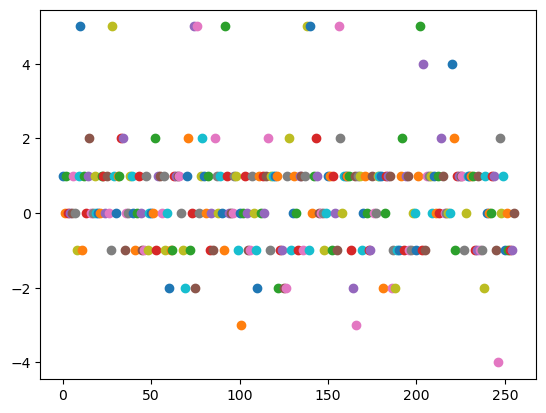

In [18]:
with torch.inference_mode():
    for i in range(64):
        plt.scatter(i, (np.round(spectral_model(test_features[i]).item())-test_labels[i]))
        
    for i in range(64):
        plt.scatter(i+1*64, (np.round(spectral_model(test_features2[i]).item())-test_labels[i]))

    for i in range(64):
            plt.scatter(i+2*64, (np.round(spectral_model(test_features3[i]).item())-test_labels[i]))
        
    for i in range(64):
        plt.scatter(i+3*64, (np.round(spectral_model(test_features4[i]).item())-test_labels[i]))